# 0. Install and Import dependencies

In [16]:
#!pip install stable-baselines3 gym-anytrading gym yfinance

In [17]:
# Gym stuff
import gymnasium as gym
import gym_anytrading

# Data API
import yfinance as yf

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
import os

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

# 1. Bring in Data 
This function fetches stock data from Yahoo Finance for the period 2024-01-01 to 2025-01-31.
It then cleans and processes the data, splitting it into:
1. Training set (df_train) → Contains all stock data from 2021-2023.
2. Testing set (df_test) → Contains stock data of 2024.

In [18]:
# Function to fetch, clean, and split stock data
def fetch_and_prepare_stock_data(ticker):
    
    # Download stock data for 2024 and January 2025
    df = yf.Ticker(ticker).history(start="2021-01-01", end="2024-12-31", interval="1d")

    # Ensure a copy to prevent warnings
    df = df.copy()

    # Format the Date index
    df["Date"] = pd.to_datetime(df.index)  
    df.index = df.index.date  # Convert to `datetime.date` objects

    # Drop unnecessary columns
    df = df.drop(columns=['Dividends', 'Stock Splits', 'Date'])

    # Round all numerical values to 2 decimal places
    df = df.round(2)

    # ✅ Convert date strings to `datetime.date`
    train_start = datetime.strptime("2021-01-01", "%Y-%m-%d").date()
    train_end = datetime.strptime("2023-12-31", "%Y-%m-%d").date()
    test_start = datetime.strptime("2024-01-01", "%Y-%m-%d").date()
    test_end = datetime.strptime("2024-12-31", "%Y-%m-%d").date()

    # ✅ Use `.loc[]` with date objects instead of strings
    df_train = df.loc[train_start:train_end]
    df_test = df.loc[test_start:test_end]

    return df_train, df_test

In [19]:
# Fetch and prepare NVIDIA stock data
df_NVDA_train, df_NVDA_test = fetch_and_prepare_stock_data("NVDA")

#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#df_NVDA_train[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df_NVDA_train[['Open', 'High', 'Low', 'Close', 'Volume']])
#df_NVDA_test[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df_NVDA_test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [20]:
# Display results
print("Train Data (2021-2023):")
print(df_NVDA_train.head())
print("\nTest Data (2024):")
print(df_NVDA_test.head())

Train Data (2021-2023):
             Open   High    Low  Close     Volume
2021-01-04  13.07  13.62  12.93  13.08  560640000
2021-01-05  13.07  13.41  13.05  13.37  322760000
2021-01-06  13.19  13.21  12.55  12.58  580424000
2021-01-07  12.93  13.34  12.85  13.31  461480000
2021-01-08  13.33  13.39  13.01  13.24  292528000

Test Data (2024):
             Open   High    Low  Close     Volume
2024-01-02  49.23  49.28  47.58  48.15  411254000
2024-01-03  47.47  48.17  47.31  47.56  320896000
2024-01-04  47.75  48.49  47.49  47.98  306535000
2024-01-05  48.45  49.53  48.29  49.08  415039000
2024-01-08  49.50  52.26  49.46  52.24  642510000


In [21]:
df_NVDA_train.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

# 2. Build and Test Env

In [22]:
env = gym.make('stocks-v0', df=df_NVDA_train, frame_bound=(5,250), window_size=5)

In [23]:
print(env.unwrapped.prices) #By default, gym-anytrading uses the Close Price as prices.

[13.08 13.37 12.58 13.31 13.24 13.59 13.45 13.5  13.17 12.83 12.99 13.33
 13.83 13.68 13.62 13.4  12.89 13.02 12.96 13.2  13.52 13.5  13.63 13.56
 14.4  14.23 14.73 15.21 14.92 15.29 14.87 14.79 14.89 14.32 14.11 14.46
 13.27 13.68 13.81 13.37 12.77 12.34 12.43 11.56 12.49 12.44 12.97 12.83
 13.16 13.26 13.31 12.69 12.82 13.16 13.04 12.62 12.51 12.81 12.92 12.84
 13.32 13.78 13.96 13.83 14.11 14.29 14.37 15.18 15.65 15.24 16.1  15.88
 15.33 15.14 15.33 14.82 15.23 15.44 15.35 15.24 15.29 14.98 14.8  14.32
 14.43 14.49 14.78 14.23 14.27 13.73 13.64 14.21 14.13 13.99 14.03 14.58
 14.96 15.58 15.61 15.67 15.45 16.21 16.23 16.74 16.93 17.54 17.58 17.42
 17.32 17.39 17.79 17.98 17.75 17.78 18.62 18.6  18.39 18.85 19.02 19.17
 18.99 19.95 19.99 19.96 20.17 20.45 20.66 20.33 19.86 20.01 20.47 20.21
 19.8  18.93 18.13 18.74 18.58 19.37 19.56 19.52 19.26 19.17 19.46 19.62
 19.46 19.71 19.78 20.23 20.6  20.33 20.26 19.9  19.66 19.87 20.15 19.91
 19.42 19.   19.76 20.78 21.91 21.75 22.17 22.02 22

In [24]:
env.action_space

Discrete(2)

Run 1:
info: {'total_reward': np.float32(7.9700127), 'total_profit': np.float32(0.52653134), 'position': <Positions.Long: 1>}


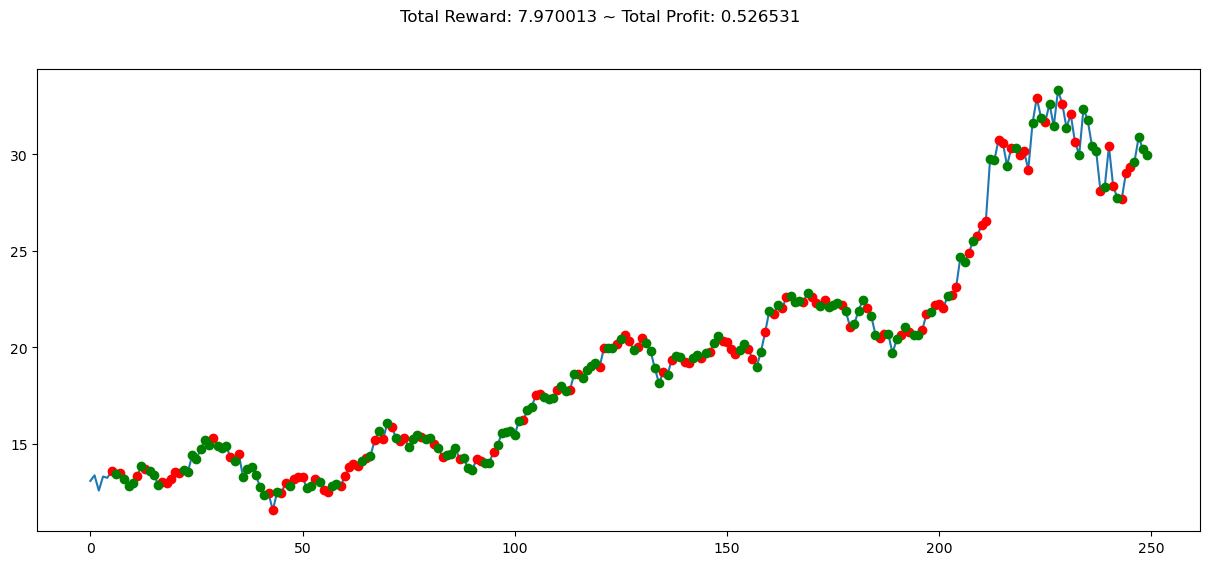

Run 2:
info: {'total_reward': np.float32(11.329999), 'total_profit': np.float32(0.64382964), 'position': <Positions.Short: 0>}


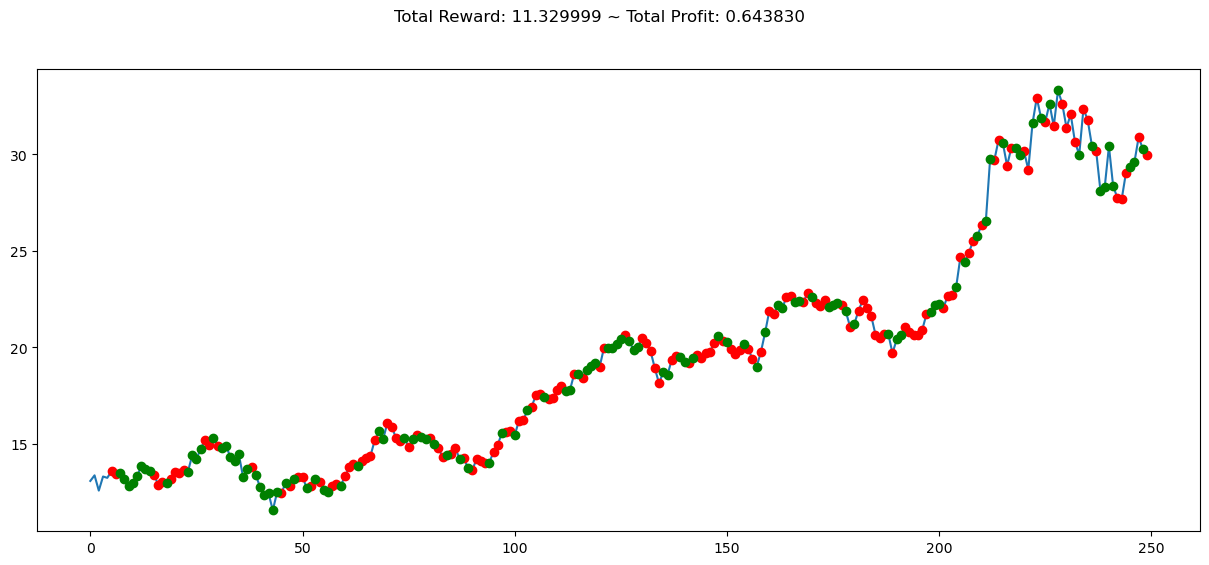

Run 3:
info: {'total_reward': np.float32(10.220005), 'total_profit': np.float32(0.56034976), 'position': <Positions.Short: 0>}


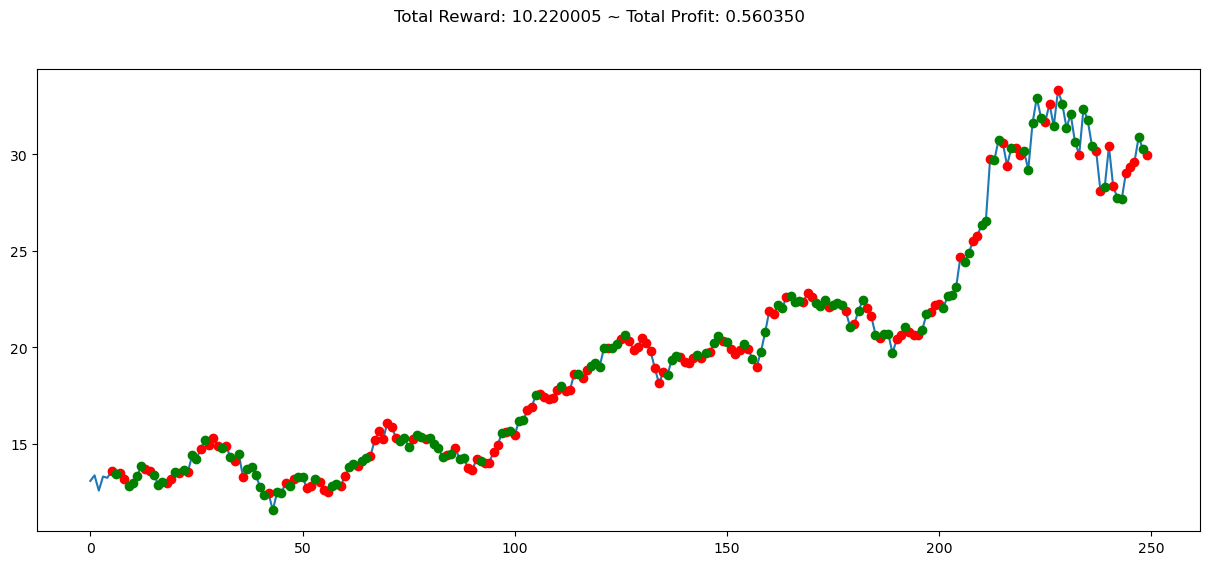

In [25]:
for i in range(3):  # Run multiple times
    print(f"Run {i+1}:")

    # Reset environment with a random seed
    state = env.reset(seed=np.random.randint(1000))  

    while True:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated
        if done:
            print("info:", info)
            break

    # Plot results for this run
    plt.figure(figsize=(15,6))
    plt.cla()
    env.unwrapped.render_all()
    plt.show()

# 3. Build Environment and Train

In [26]:
# Create a lambda function that initializes the environment
def env_maker():
    return gym.make('stocks-v0', df=df_NVDA_train, frame_bound=(10, len(df_NVDA_train)), window_size=10)

# Wrap in DummyVecEnv
env = DummyVecEnv([env_maker])

In [27]:
# Create a directory to save models
save_dir = "./logs/"
os.makedirs(save_dir, exist_ok=True)

# ✅ Custom Callback to Print Message When a New Best Model is Found
class CustomCallback(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)

    def _on_step(self):
        print(f"🔥 New best model found at step {self.num_timesteps}!")
        return True
        
# ✅ Create Evaluation Environment (Separate from Training)
eval_env = DummyVecEnv([env_maker])  # Use the same env_maker as training

# ✅ Define `EvalCallback` with `callback_on_new_best`
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path=save_dir, 
    log_path=save_dir, 
    eval_freq=5000,  # Evaluate every 5000 timesteps
    deterministic=True, 
    render=False,
    callback_on_new_best=CustomCallback()
)

In [28]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000, callback=eval_callback)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 1743     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.657   |
|    explained_variance | -1.44    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00705 |
|    value_loss         | 0.000466 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1738     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | -0.0104  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.367   |
|    value_loss      

/Users/hsienpanghsieh/Library/jupyterlab-desktop/envs/rl_env/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00
Episode length: 742.00 +/- 0.00
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 742      |
|    mean_reward        | 0        |
| time/                 |          |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -0.68    |
|    explained_variance | 0.969    |
|    learning_rate      | 0.0007   |
|    n_updates          | 999      |
|    policy_loss        | -0.0116  |
|    value_loss         | 0.000374 |
------------------------------------
New best mean reward!
🔥 New best model found at step 5000!
-----------------------------
| time/              |      |
|    fps             | 1408 |
|    iterations      | 1000 |
|    time_elapsed    | 3    |
|    total_timesteps | 5000 |
-----------------------------
------------------------------------
| time/                 |          |
|    fps                | 1433     |
|    iterations 

# 4. Evaluation

In [29]:
# ✅ Load the Best Model
best_model = A2C.load("./logs/best_model")

# ✅ Create Testing Environment
test_env = gym.make('stocks-v0', df=df_NVDA_test, frame_bound=(10, len(df_NVDA_test)), window_size=10)

# ✅ Reset Environment
obs, _ = test_env.reset()

# ✅ Evaluate Model on Test Dataset
while True:
    action, _states = best_model.predict(obs, deterministic=True)  # Ensure deterministic evaluation
    obs, reward, terminated, truncated, info = test_env.step(action)

    # ✅ Fix: Access `_current_tick` from `unwrapped` version
    print(f"Step: {test_env.unwrapped._current_tick}, Action: {action}, Reward: {reward:.2f}")

    if terminated or truncated:  # Proper episode ending check
        print("Final Test Performance:", info)
        break

Step: 11, Action: 1, Reward: 0.00
Step: 12, Action: 0, Reward: 2.38
Step: 13, Action: 0, Reward: 0.00
Step: 14, Action: 0, Reward: 0.00
Step: 15, Action: 1, Reward: 0.00
Step: 16, Action: 1, Reward: 0.00
Step: 17, Action: 1, Reward: 0.00
Step: 18, Action: 1, Reward: 0.00
Step: 19, Action: 1, Reward: 0.00
Step: 20, Action: 1, Reward: 0.00
Step: 21, Action: 1, Reward: 0.00
Step: 22, Action: 1, Reward: 0.00
Step: 23, Action: 0, Reward: 7.97
Step: 24, Action: 0, Reward: 0.00
Step: 25, Action: 1, Reward: 0.00
Step: 26, Action: 1, Reward: 0.00
Step: 27, Action: 1, Reward: 0.00
Step: 28, Action: 0, Reward: 2.15
Step: 29, Action: 1, Reward: 0.00
Step: 30, Action: 0, Reward: 1.77
Step: 31, Action: 1, Reward: 0.00
Step: 32, Action: 1, Reward: 0.00
Step: 33, Action: 1, Reward: 0.00
Step: 34, Action: 1, Reward: 0.00
Step: 35, Action: 1, Reward: 0.00
Step: 36, Action: 0, Reward: 6.15
Step: 37, Action: 0, Reward: 0.00
Step: 38, Action: 1, Reward: 0.00
Step: 39, Action: 1, Reward: 0.00
Step: 40, Acti

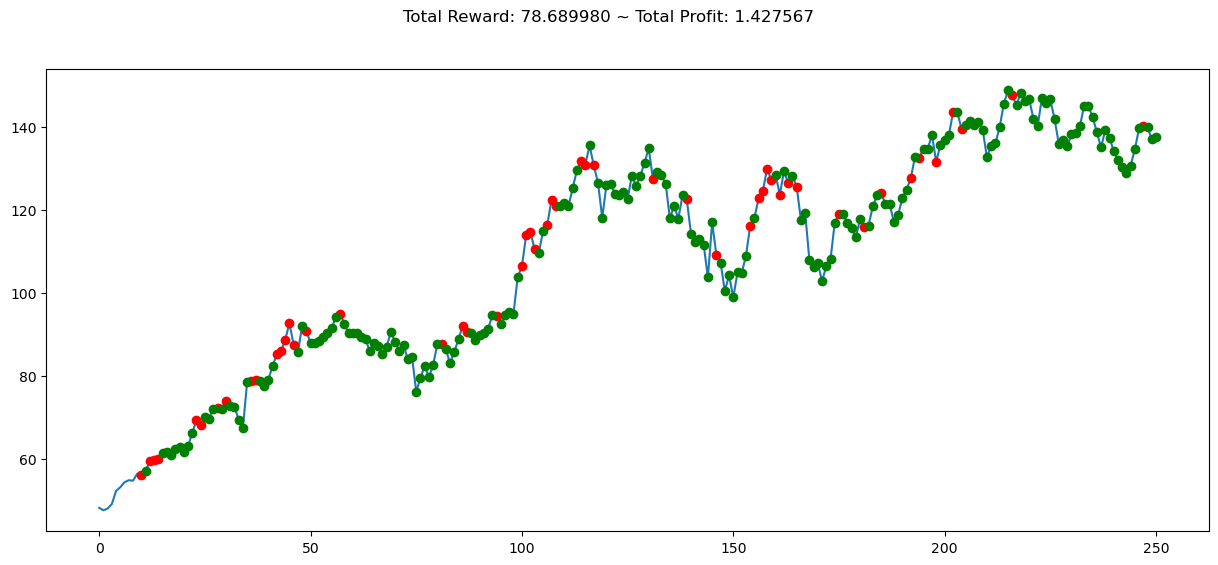

In [30]:
plt.figure(figsize=(15,6))
plt.cla()
test_env.unwrapped.render_all()
plt.show()